In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path

PosixPath('/tmp/.fastai/data/camvid')

In [4]:
path.ls()

[PosixPath('/tmp/.fastai/data/camvid/images'),
 PosixPath('/tmp/.fastai/data/camvid/codes.txt'),
 PosixPath('/tmp/.fastai/data/camvid/labels'),
 PosixPath('/tmp/.fastai/data/camvid/valid.txt')]

In [5]:
path_img = path/'images'
path_label = path/'labels'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/tmp/.fastai/data/camvid/images/0016E5_05040.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f01920.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f02100.png')]

In [7]:
label_names = get_image_files(path_label)
label_names[:3]

[PosixPath('/tmp/.fastai/data/camvid/labels/0016E5_00570_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/Seq05VD_f04830_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0016E5_01080_P.png')]

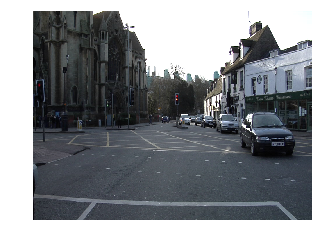

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'

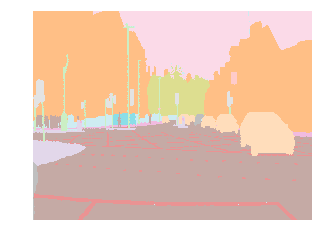

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5))

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [14]:
size = src_size//2
bs = 8

In [15]:
codes = np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn,classes = codes))

In [17]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
       .databunch(bs=bs,num_workers=0)
       .normalize(imagenet_stats))

In [18]:
print(data.classes)
print(data.c)
(len(data.classes))

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']
32


32

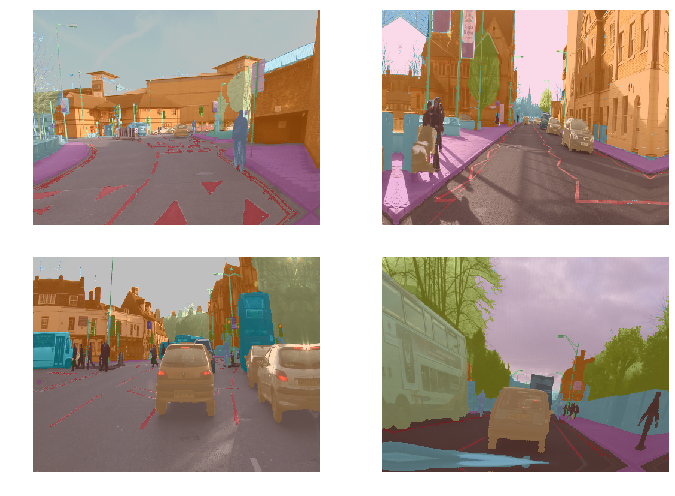

In [19]:
data.show_batch(rows=2,figsize=(10,7))

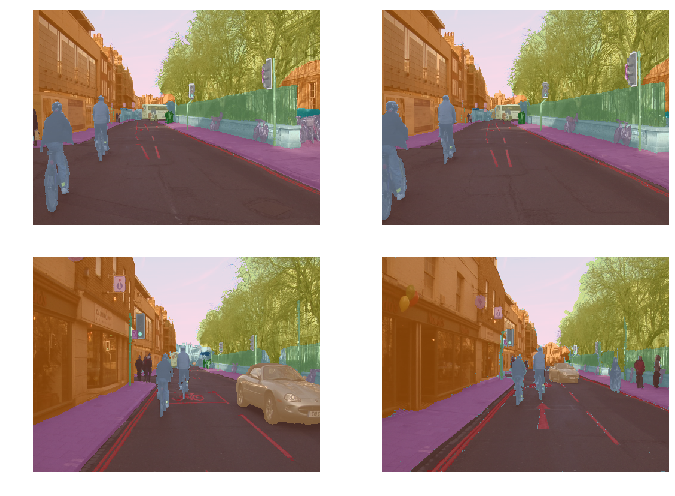

In [20]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)

In [30]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input,target):
    target=target.squeeze(1)
    mask = target!=void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [31]:
metrics = acc_camvid

In [32]:
wd=1e-2

In [33]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

In [34]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


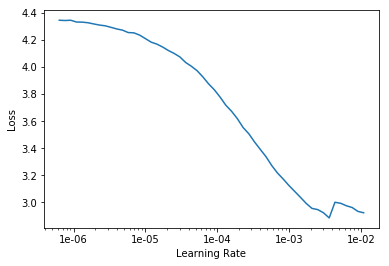

In [35]:
learn.recorder.plot()

In [36]:
lr = 1e-3

In [37]:
learn.fit_one_cycle(3,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.417152,0.843404,0.793218,01:41
1,0.884778,0.662347,0.838534,01:37
2,0.831734,0.590766,0.840418,01:37


In [38]:
learn.save('Stage1')

In [40]:
learn.load('Stage1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /tmp/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /tmp/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

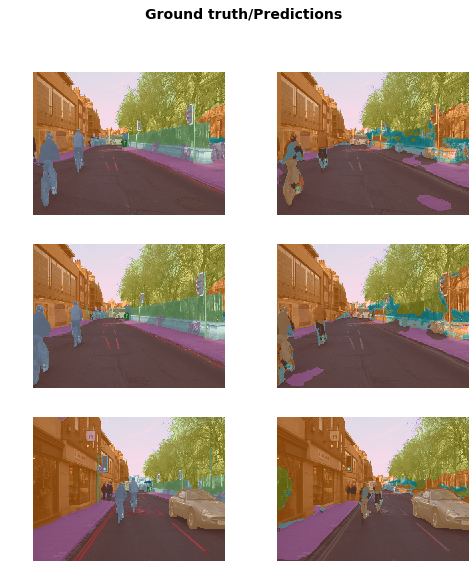

In [41]:
learn.show_results(rows=3,figsize=(8,9))

In [42]:
learn.unfreeze()

In [43]:
lrs = slice(lr/400,lr/4)

In [45]:
learn.fit_one_cycle(5,lrs,pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.591847,0.507865,0.855349,01:39
1,0.552131,0.477757,0.862451,01:38
2,0.514227,0.397099,0.886505,01:38
3,0.482733,0.374020,0.897342,01:38
4,0.425327,0.350744,0.898267,01:38


In [46]:
learn.save('Stage2')